# How to create subgraphs

For more complex systems, sub-graphs are a useful design principle. Sub-graphs allow you to create and manage different state variable in different parts of your graph. This allows you build things like [multi-agent teams](./multi_agent/hierarchical_agent_teams.ipynb), where each team can track its own separate state.

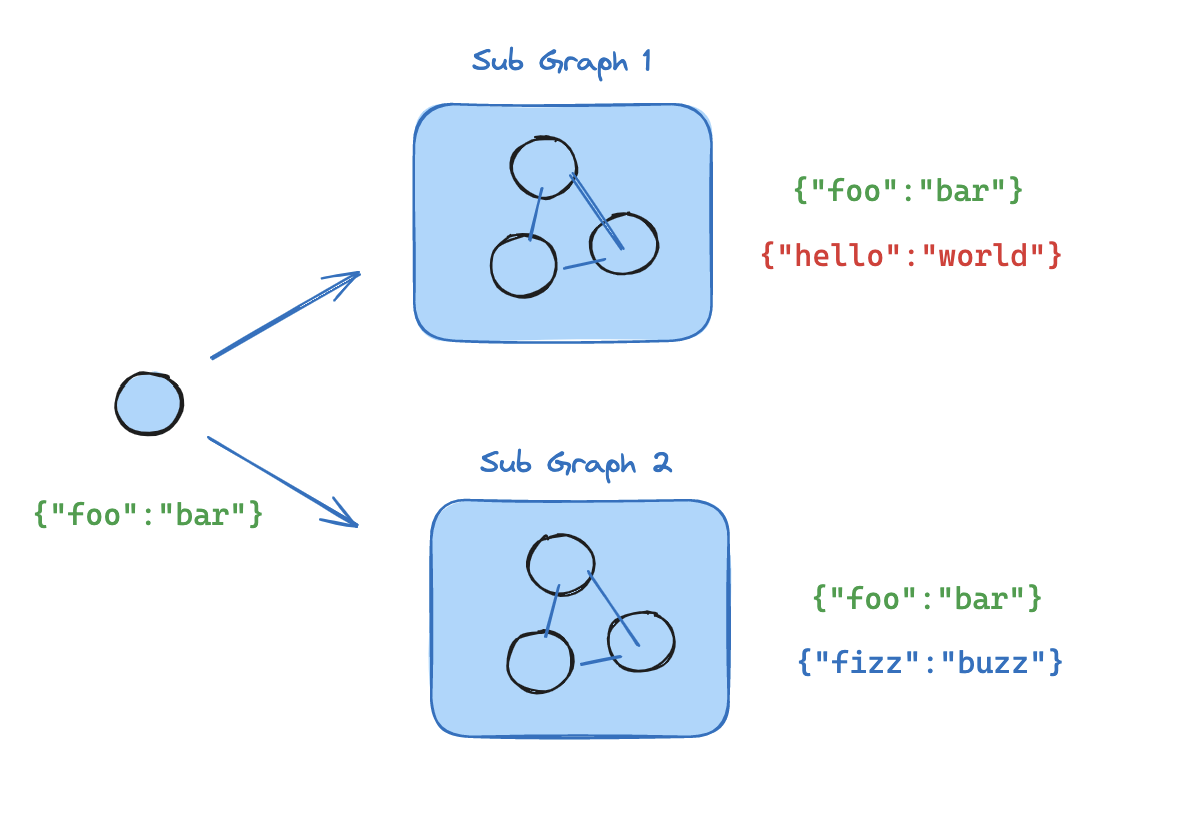

In [2]:
%%capture --no-stderr
%pip install -U langgraph

## Simple example

Let's consider a toy example: I have a system that accepts logs and perform two separate sub-tasks. First, it will summarize them. Second, it will summarize any failure modes. I want to perform these two operations in two different sub-graphs.

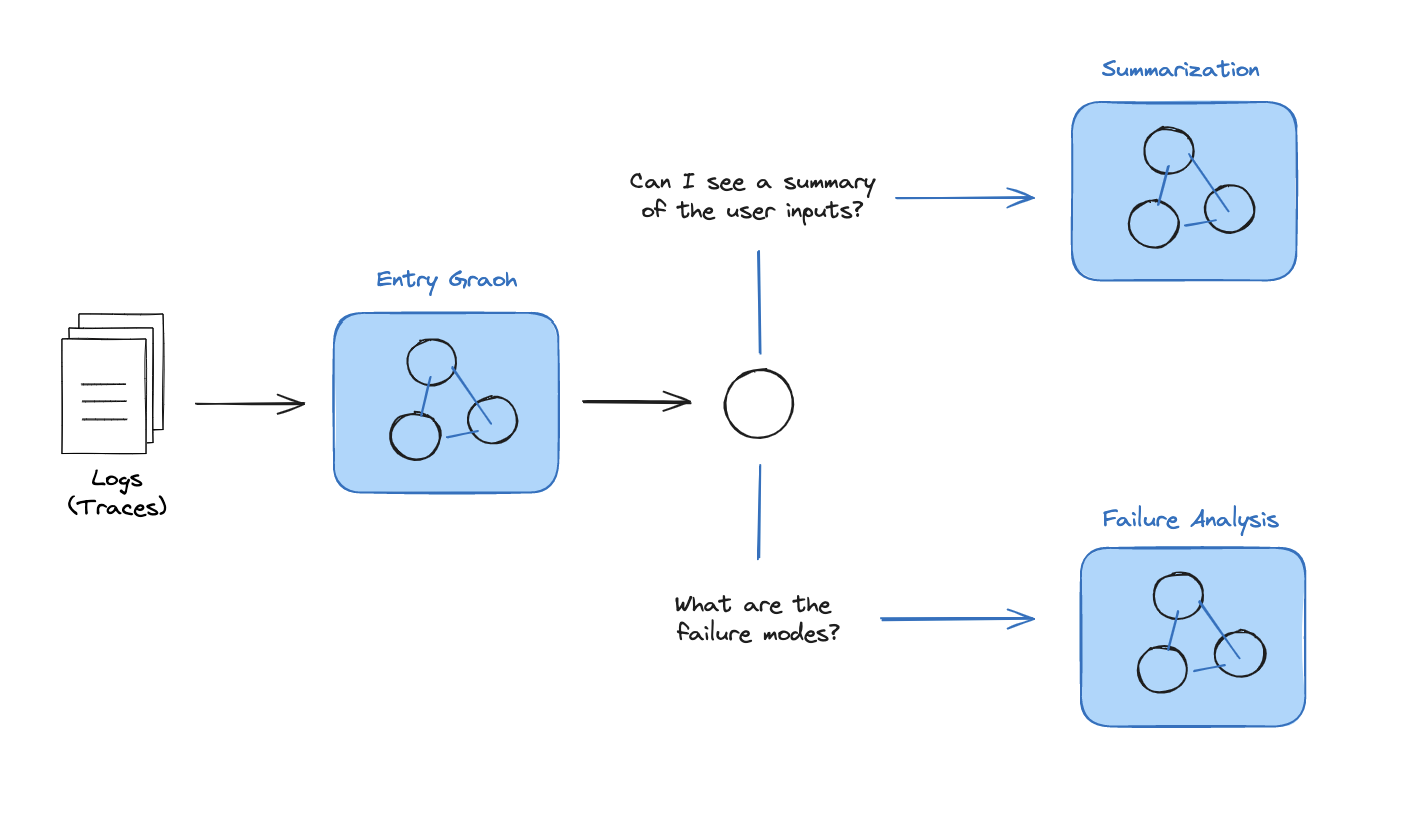

In [12]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

# Type
class Logs(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str    
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]  

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    docs: List[Logs]
    failures: List[Logs]
    fa_summary: str

def get_failures(state):
    docs = state['docs']
    failures = [doc for doc in docs if "grade" in doc]
    return {"failures": failures}

def generate_summary(state):
    failures = state['failures']
    fa_summary = "Poor quality retrieval of Chroma documentation." 
    return {"fa_summary": fa_summary}

fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.set_entry_point("get_failures")
fa_builder.add_edge("get_failures","generate_summary")
fa_builder.set_finish_point("generate_summary")

# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    filtered_docs: Annotated[List[Logs], add]
    qs_summary: str
    report: str

def generate_summary(state):
    filtered_docs = state['filtered_docs']
    summary = "Questions focused on usage of ChatOllama and Chroma vector store." 
    return {"qs_summary": summary}

def send_to_slack(state):
    qs_summary = state['qs_summary']
    report = qs_summary
    return {"report": report}

def format_report_for_slack(state):
    report = state['report']
    formatted_report = "foo bar"
    return {"report": formatted_report}

qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_node("format_report_for_slack", format_report_for_slack)
qs_builder.set_entry_point("generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", "format_report_for_slack")
qs_builder.add_edge("format_report_for_slack", END)

Note that each sub-graph has its own state, `QuestionSummarizationState` and `FailureAnalysisState`.
 
After defining each sub-graph, we can define a final entry graph, and put everything together.

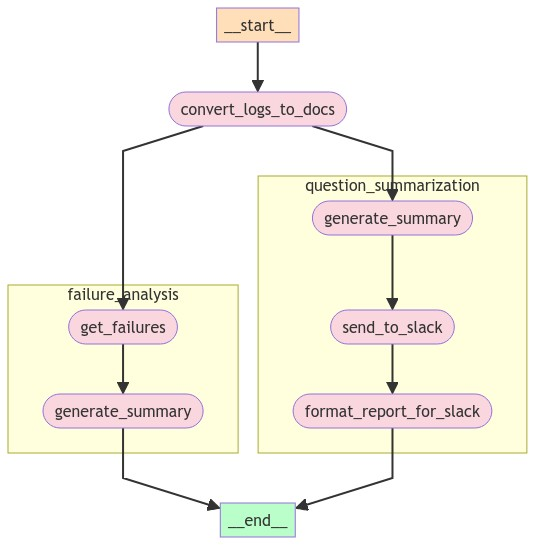

In [13]:
# Entry Graph

class EntryGraphState(TypedDict):
    raw_logs: Annotated[List[Dict], add]
    docs: Annotated[List[RagAppOutput], add] # This will be used in sub-graph
    fa_summary: str # This will be generated in the sub-graph
    qs_summary: str # This will be generated in the sub-graph

def convert_logs_to_docs(state):
    # Get logs
    raw_logs = state['raw_logs']
    docs = [question_answer,question_answer_feedback]
    return {"docs": docs} 

# Dummpy docs
question_answer = RagAppOutput(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = RagAppOutput(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("convert_logs_to_docs", convert_logs_to_docs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.set_entry_point("convert_logs_to_docs")
entry_builder.add_edge("convert_logs_to_docs", "failure_analysis")
entry_builder.add_edge("convert_logs_to_docs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display
# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
raw_logs = [{"foo":"bar"},{"foo":"baz"}]
graph.invoke({"raw_logs": raw_logs}, debug=False)

{'raw_logs': [{'foo': 'bar'}, {'foo': 'baz'}],
 'docs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'},
  {'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss 

## Custom reducer functions to manage state

Now, let's highlight a possible stumbling block when we use the same `State` across multiple sub-graphs.
 
We will create two graphs: a parent graph with a few nodes, and a child graph that is added as a node in the parent.

We define a custom [reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) function for our state.

In [15]:
from typing import Annotated

from typing_extensions import TypedDict




def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_edge(START, "child_start")
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.add_edge("child_end", END)

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.add_edge("fin", END)
graph = builder.compile()

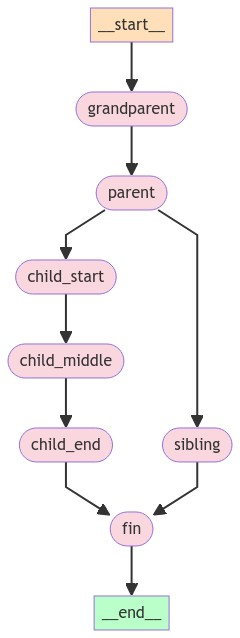

In [3]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[0:checkpoint] State at the end of step 0:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[1:checkpoint] State at the end of step 1:
{'name': 'test', 'path': ['grandparent']}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test', 'path': ['grandparent']}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[2:checkpoint] State at the end of step 2:
{'name': 'test', 'path': ['grandparent', 'parent']}
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test', 'path': ['grandparent', 'parent']}
- sibling -> {'name': 'test', 'path': ['grandparent', 'parent']}
[3:writes] Finished step 3 with writes to 2 channels:
- name -> 'test'
- path -> ['grandparent', 'parent', '

{'name': 'test',
 'path': ['grandparent',
  'parent',
  'grandparent',
  'parent',
  'child_start',
  'child_middle',
  'child_end',
  'sibling',
  'fin']}

Notice here that the `["grandparent", "parent"]` sequence is duplicated! 

This is because our child state has received the full parent state and returns the full parent state once it terminates. To avoid duplication or conflicts in state, you typically would do one or more of the following:

1. Handle duplicates in your `reducer` function.
2. Call the child graph from within a python function. In that function, handle the state as needed.  
3. Update the child graph keys to avoid conflicts. You would still need to ensure the output can be interpreted by the parent, however.

Let's re-implement the graph using technique (1) and add unique IDs for every value in the list. This is what is done in [`MessageGraph`](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph).

In [23]:
import uuid


def reduce_list(left: list | None, right: list | None) -> list:
    """Append the right-hand list, replacing any elements with the same id in the left-hand list."""
    if not left:
        left = []
    if not right:
        right = []
    left_, right_ = [], []
    for orig, new in [(left, left_), (right, right_)]:
        for val in orig:
            if not isinstance(val, dict):
                val = {"val": val}
            if "id" not in val:
                val["id"] = str(uuid.uuid4())
            new.append(val)
    # Merge the two lists
    left_idx_by_id = {val["id"]: i for i, val in enumerate(left_)}
    merged = left_.copy()
    for val in right_:
        if (existing_idx := left_idx_by_id.get(val["id"])) is not None:
            merged[existing_idx] = val
        else:
            merged.append(val)
    return merged


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]

In [24]:
child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_edge(START, "child_start")
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.add_edge("child_end", END)

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.add_edge("fin", END)
graph = builder.compile()

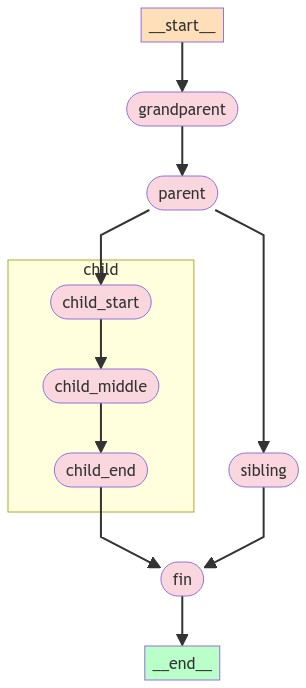

In [25]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[0:checkpoint] State at the end of step 0:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[1:checkpoint] State at the end of step 1:
{'name': 'test',
 'path': [{'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49', 'val': 'grandparent'}]}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test',
 'path': [{'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49', 'val': 'grandparent'}]}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[2:checkpoint] State at the end of step 2:
{'name': 'test',
 'path': [{'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49', 'val': 'grandparent'},
          {'id': '2a6f0263-3949-4e47-a210-57f817e6097d', 'val': 'parent'}]}
[3:tasks] Starting step 3 with 2 tasks:
- c

{'name': 'test',
 'path': [{'val': 'grandparent', 'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49'},
  {'val': 'parent', 'id': '2a6f0263-3949-4e47-a210-57f817e6097d'},
  {'val': 'child_start', 'id': 'd1c1bab0-6e19-4846-a470-e9cc2eb85088'},
  {'val': 'child_middle', 'id': 'e0fcb647-1e9e-4ae4-b560-0046515d5783'},
  {'val': 'child_end', 'id': '669dd810-360f-4694-a9f3-49597f23376a'},
  {'val': 'sibling', 'id': '137dbc2f-b33c-4ea4-8b04-a62215ba9718'},
  {'val': 'fin', 'id': 'a4328c5f-845a-43de-b3d7-53a39208e316'}]}